## Import Libraries 

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import nltk
nltk.download('stopwords')
from nltk.corpus import stopwords
from nltk.stem import PorterStemmer
import string
from sklearn.feature_extraction.text import TfidfVectorizer

nltk.download('stopwords')
nltk.download('punkt')

from wordcloud import WordCloud

# define the stemmer and stopwords
stemmer = PorterStemmer()
stop_words = set(stopwords.words('english'))


from sklearn.metrics import recall_score, precision_score
from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import CountVectorizer, TfidfTransformer
from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC
from sklearn.metrics import classification_report, f1_score, accuracy_score, confusion_matrix
from gensim.models import Word2Vec
from gensim.models.keyedvectors import KeyedVectors
from sklearn.model_selection import GridSearchCV
from sklearn.tree import DecisionTreeClassifier
import random

[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\vilis\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\vilis\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package punkt to
[nltk_data]     C:\Users\vilis\AppData\Roaming\nltk_data...
[nltk_data]   Package punkt is already up-to-date!


## Import data

In [2]:
df_train = pd.read_csv("yahoo_train.csv")

In [3]:
df_train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1400000 entries, 0 to 1399999
Data columns (total 10 columns):
 #   Column            Non-Null Count    Dtype 
---  ------            --------------    ----- 
 0   id                1400000 non-null  int64 
 1   topic             1400000 non-null  int64 
 2   question_title    1400000 non-null  object
 3   question_content  768325 non-null   object
 4   best_answer       1375421 non-null  object
 5   topic_name        1400000 non-null  object
 6   title_clean       1396823 non-null  object
 7   content_clean     764929 non-null   object
 8   answer_clean      1369225 non-null  object
 9   text_clean        1400000 non-null  object
dtypes: int64(2), object(8)
memory usage: 106.8+ MB


### Define clean dataset

+ Variables 'topic', 'topic_name' and 'text_clean'

In [6]:
df_clean = df_train[['topic','topic_name','text_clean']]

### Filtering topics

+ Filter topics 0,1,2.

In [7]:
df_clean = df_clean[df_clean.topic.isin([0,1,2])]

In [50]:
df_clean.info()


<class 'pandas.core.frame.DataFrame'>
Int64Index: 420000 entries, 2 to 1399998
Data columns (total 4 columns):
 #   Column      Non-Null Count   Dtype 
---  ------      --------------   ----- 
 0   topic       420000 non-null  int64 
 1   topic_name  420000 non-null  object
 2   text_clean  420000 non-null  object
 3   noun_text   420000 non-null  object
dtypes: int64(1), object(3)
memory usage: 16.0+ MB


### Metrics

In [9]:
def get_metrics(y_trues, y_preds, verbose=True):

  recall = recall_score(y_trues, y_preds) * 100
  precision = precision_score(y_trues, y_preds) * 100

  if verbose:
    print(f'Precision: {precision:.2f}')
    print(f'Recall: {recall:.2f}')

  return recall, precision

## Baseline models

### Ruled based model

+ Gets as inputs a dictionnary for each topic with the fifty most common words
+ For each sentence find the dictionary with more coincidences and classify the text under that topic
+ Calculate precision, recall, f1-score and the confusion matrix for the model


In [11]:
topics = df_clean.groupby('topic')['text_clean'].apply(list)

# Preprocess the text data for each topic
tfidf = TfidfVectorizer()
tfidf_matrix = tfidf.fit_transform(topics.apply(lambda x: ' '.join(x)))

# Extract the top 10 keywords for each topic
feature_names = tfidf.get_feature_names()
keywords = {}
for topic in topics.index:
    index = topics.index.get_loc(topic)
    feature_index = tfidf_matrix[index,:].nonzero()[1]
    tfidf_scores = zip(feature_index, [tfidf_matrix[index, x] for x in feature_index])
    sorted_scores = sorted(tfidf_scores, key=lambda x: x[1], reverse=True)
    top_keywords = [feature_names[i] for i, score in sorted_scores[:50]]
    keywords[topic] = top_keywords

print(keywords)

C:\Users\vilis\anaconda3\lib\site-packages\sklearn\utils\deprecation.py:87: FutureWarning: Function get_feature_names is deprecated; get_feature_names is deprecated in 1.0 and will be removed in 1.2. Please use get_feature_names_out instead.
  warnings.warn(msg, category=FutureWarning)


{0: ['god', 'people', 'would', 'one', 'like', 'know', 'think', 'get', 'jesus', 'good', 'believe', 'life', 'say', 'time', 'many', 'want', 'us', 'go', 'way', 'also', 'really', 'make', 'bible', 'love', 'see', 'even', 'world', 'could', 'question', 'religion', 'things', 'day', 'person', 'man', 'something', 'someone', 'need', 'right', 'much', 'well', 'find', 'anyone', 'help', 'first', 'said', 'never', 'thing', 'mean', 'christian', 'church'], 1: ['would', 'one', 'water', 'like', 'time', 'know', 'get', 'also', 'earth', 'light', 'two', 'many', 'energy', 'need', '10', 'answer', 'find', 'use', 'help', 'number', 'http', 'used', 'question', 'see', 'first', 'could', 'make', 'think', 'much', 'way', 'people', 'may', 'different', 'mass', 'air', 'good', 'called', 'please', 'years', 'even', 'go', 'well', 'take', 'point', 'space', 'work', 'since', 'speed', 'sun', 'www'], 2: ['get', 'like', 'know', 'help', 'good', 'one', 'would', 'also', 'go', 'weight', 'time', 'need', 'take', 'body', 'people', 'may', 'rea

In [12]:
from nltk import pos_tag
from nltk.tokenize import word_tokenize
def keep_nouns(text):
    # Tokenize the text
    tokens = word_tokenize(text)
    
    # Get the POS tags
    pos_tags = pos_tag(tokens)
    
    # Keep only the nouns
    nouns = [word for word, pos in pos_tags if pos.startswith('N')]
    
    # Join the nouns into a single string
    preprocessed_text = ' '.join(nouns)
    
    return preprocessed_text

In [13]:
df_clean['noun_text'] = df_clean['text_clean'].apply(keep_nouns)

In [14]:
topics = df_clean.groupby('topic')['text_clean'].apply(list)

# Preprocess the text data for each topic
tfidf = TfidfVectorizer()
tfidf_matrix = tfidf.fit_transform(topics.apply(lambda x: ' '.join(x)))

# Extract the top 10 keywords for each topic
feature_names = tfidf.get_feature_names()
keywords = {}
for topic in topics.index:
    index = topics.index.get_loc(topic)
    feature_index = tfidf_matrix[index,:].nonzero()[1]
    tfidf_scores = zip(feature_index, [tfidf_matrix[index, x] for x in feature_index])
    sorted_scores = sorted(tfidf_scores, key=lambda x: x[1], reverse=True)
    top_keywords = [feature_names[i] for i, score in sorted_scores[:50]]
    keywords[topic] = top_keywords

print(keywords)

C:\Users\vilis\anaconda3\lib\site-packages\sklearn\utils\deprecation.py:87: FutureWarning: Function get_feature_names is deprecated; get_feature_names is deprecated in 1.0 and will be removed in 1.2. Please use get_feature_names_out instead.
  warnings.warn(msg, category=FutureWarning)


{0: ['god', 'people', 'would', 'one', 'like', 'know', 'think', 'get', 'jesus', 'good', 'believe', 'life', 'say', 'time', 'many', 'want', 'us', 'go', 'way', 'also', 'really', 'make', 'bible', 'love', 'see', 'even', 'world', 'could', 'question', 'religion', 'things', 'day', 'person', 'man', 'something', 'someone', 'need', 'right', 'much', 'well', 'find', 'anyone', 'help', 'first', 'said', 'never', 'thing', 'mean', 'christian', 'church'], 1: ['would', 'one', 'water', 'like', 'time', 'know', 'get', 'also', 'earth', 'light', 'two', 'many', 'energy', 'need', '10', 'answer', 'find', 'use', 'help', 'number', 'http', 'used', 'question', 'see', 'first', 'could', 'make', 'think', 'much', 'way', 'people', 'may', 'different', 'mass', 'air', 'good', 'called', 'please', 'years', 'even', 'go', 'well', 'take', 'point', 'space', 'work', 'since', 'speed', 'sun', 'www'], 2: ['get', 'like', 'know', 'help', 'good', 'one', 'would', 'also', 'go', 'weight', 'time', 'need', 'take', 'body', 'people', 'may', 'rea

In [51]:
def rule_based_model(text):
    # Extract the words from the text
    words = set(text.split())
    # Find the topic with the most matching keywords
    max_matches = 0
    best_topic = None
    for topic, topic_keywords in keywords.items():
        matches = len(words.intersection(topic_keywords))
        if matches > max_matches:
            max_matches = matches
            best_topic = topic
    if best_topic is None:
        best_topic = random.randint(0,2)
    return best_topic

In [52]:
y_pred_rule = df_clean['text_clean'].apply(rule_based_model)

In [54]:
print('Rule-based model:')
print('Accuracy Score:', accuracy_score(df_clean['topic'], y_pred_rule))
print(classification_report(df_clean['topic'], y_pred_rule))

Rule-based model:
Accuracy Score: 0.5968666666666667
              precision    recall  f1-score   support

           0       0.53      0.76      0.63    140000
           1       0.64      0.52      0.57    140000
           2       0.67      0.51      0.58    140000

    accuracy                           0.60    420000
   macro avg       0.61      0.60      0.59    420000
weighted avg       0.61      0.60      0.59    420000



In [43]:
#Confussion Matrix 

from sklearn.metrics import plot_confusion_matrix
from sklearn.metrics import confusion_matrix

#Plot confusion matrix
def plot_cm(y_true, y_pred, figsize=(6,6)):
    cm = confusion_matrix(y_true, y_pred, labels=np.unique(y_true))
    cm_sum = np.sum(cm, axis=1, keepdims=True)
    cm_perc = cm / cm_sum.astype(float) * 100
    annot = np.empty_like(cm).astype(str)
    nrows, ncols = cm.shape
    for i in range(nrows):
        for j in range(ncols):
            c = cm[i, j]
            p = cm_perc[i, j]
            if i == j:
                s = cm_sum[i]
                annot[i, j] = '%.1f%%\n%d/%d' % (p, c, s)
            elif c == 0:
                annot[i, j] = '0.0%'
            else:
                annot[i, j] = '%.1f%%\n%d' % (p, c)
    cm = pd.DataFrame(cm, index=np.unique(y_true), columns=np.unique(y_true))
    cm.index.name = 'True Values'
    cm.columns.name = 'Predicted Values'
    fig, ax = plt.subplots(figsize=figsize)
    
    sns.heatmap(cm, cmap= "YlGnBu", annot=annot, fmt='', ax=ax)

<Figure size 3000x1000 with 0 Axes>

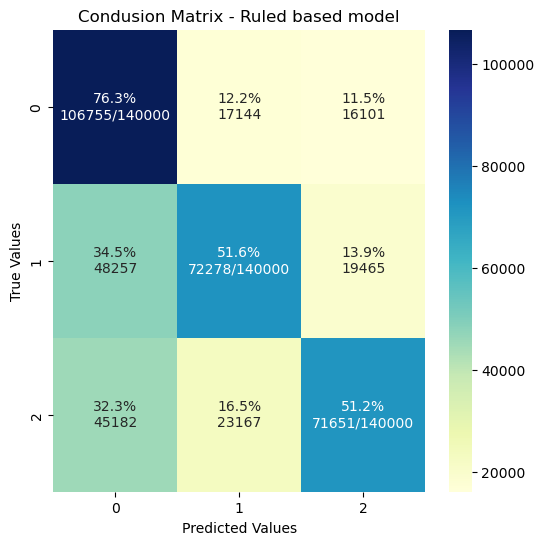

In [61]:
#Matrix
plt.figure(figsize=(30,10))
plot_cm(df_clean['topic'], y_pred_rule)
plt.title("Confusion Matrix - Ruled based model")
plt.show()

+ First approach to a clasificatio model
+ The model seems to perform better with the classification of topics related to topic 0
+ The performance decreases in a 25% for the topics 1 and 2

### TF-IDF + Logistic Regression

+ Create a bag of words with Count Vectorizer 
+ Use a TF-IDF transformer
+ Run a Logistic Regression

In [19]:
X_train, X_valid, y_train, y_valid = train_test_split(df_clean['text_clean'].tolist(), df_clean['topic'].tolist(), test_size=0.2, random_state=0, shuffle=True)

#### Create bag of words with CountVectorizer

In [20]:
vectorizer = CountVectorizer(analyzer = 'word', min_df = 10, max_df = 0.9)
X_train = vectorizer.fit_transform(X_train)
X_valid = vectorizer.transform(X_valid)

#### TF-IDF

In [21]:
tfidf_transformer = TfidfTransformer()
X_train = tfidf_transformer.fit_transform(X_train)
X_valid = tfidf_transformer.transform(X_valid)

#### LogisticRegression model

In [22]:
lr_model = LogisticRegression()
lr_model.fit(X_train, y_train)

C:\Users\vilis\anaconda3\lib\site-packages\sklearn\linear_model\_logistic.py:814: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


LogisticRegression()

In [41]:
lr_y_pred = lr_model.predict(X_valid)
print('LogisticRegression model:')
print('Accuracy Score:', accuracy_score(y_valid, lr_y_pred))
print('Confusion Matrix:\n', confusion_matrix(y_valid, lr_y_pred))
print('Classification Report:\n', classification_report(y_valid, lr_y_pred))

LogisticRegression model:
Accuracy Score: 0.8778095238095238
Confusion Matrix:
 [[24903  1426  1619]
 [ 1790 24566  1752]
 [ 2198  1479 24267]]
Classification Report:
               precision    recall  f1-score   support

           0       0.86      0.89      0.88     27948
           1       0.89      0.87      0.88     28108
           2       0.88      0.87      0.87     27944

    accuracy                           0.88     84000
   macro avg       0.88      0.88      0.88     84000
weighted avg       0.88      0.88      0.88     84000



<Figure size 3000x1000 with 0 Axes>

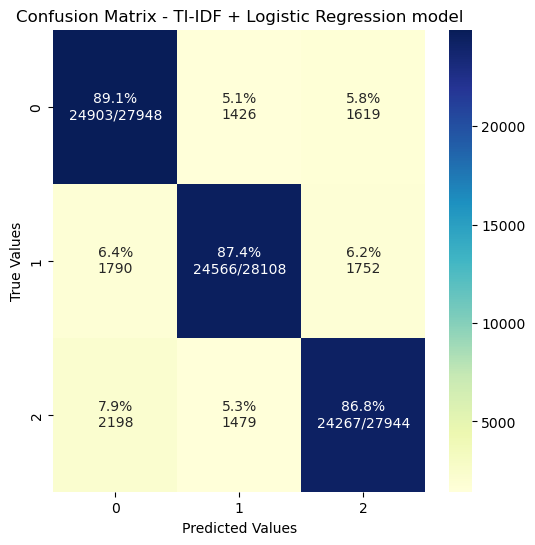

In [45]:
#Confusion Matrix
plt.figure(figsize=(30,10))
plot_cm(y_valid, lr_y_pred)
plt.title("Confusion Matrix - TI-IDF + Logistic Regression model")
plt.show()

+ Best baseline model obtained
+ Accuracy 0.88

## DecisionTree model

+ Run a Decision Tree Classifier model using the provided dataset

In [56]:
clf = DecisionTreeClassifier()

In [57]:
clf.fit(X_train, y_train)

DecisionTreeClassifier()

In [58]:
dt_y_pred = clf.predict(X_valid)
print('DecisionTree model:')
print('Accuracy Score:', accuracy_score(y_valid, dt_y_pred))
print('Confusion Matrix:\n', confusion_matrix(y_valid, dt_y_pred))
print('Classification Report:\n', classification_report(y_valid, dt_y_pred))

DecisionTree model:
Accuracy Score: 0.7185595238095238
Confusion Matrix:
 [[19947  3813  4188]
 [ 3826 20563  3719]
 [ 4407  3688 19849]]
Classification Report:
               precision    recall  f1-score   support

           0       0.71      0.71      0.71     27948
           1       0.73      0.73      0.73     28108
           2       0.72      0.71      0.71     27944

    accuracy                           0.72     84000
   macro avg       0.72      0.72      0.72     84000
weighted avg       0.72      0.72      0.72     84000



<Figure size 3000x1000 with 0 Axes>

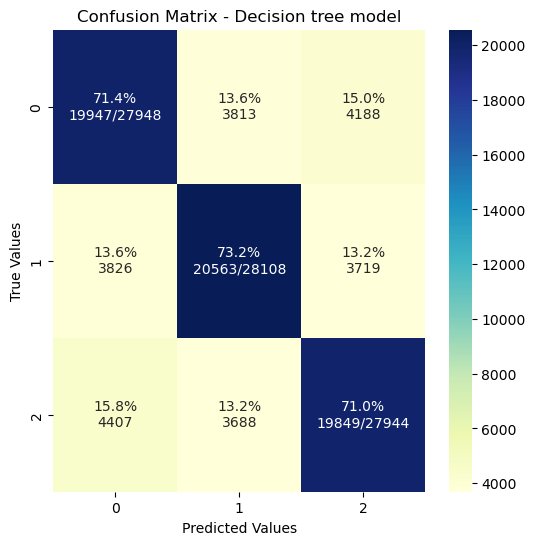

In [59]:
#Confusion Matrix
plt.figure(figsize=(30,10))
plot_cm(y_valid, dt_y_pred)
plt.title("Confusion Matrix - Decision tree model")
plt.show()

+ The obtained results are worst than the one obtained by the TF-IDF + Logistic Regression

### Error analysis

In [27]:
misclassified_texts = []
misclassified_targets = []
misclassified_predictions = []
X_valid_text = vectorizer.inverse_transform(X_valid)

for i in range(len(y_valid)):
    if y_valid[i] != lr_y_pred[i]:
        misclassified_texts.append(X_valid_text[i])
        misclassified_targets.append(y_valid[i])
        misclassified_predictions.append(lr_y_pred[i])

In [28]:
for text, target, prediction in zip(misclassified_texts, misclassified_targets, misclassified_predictions):
    print("Text:", text)
    print("True target:", target)
    print("Predicted target:", prediction)
    print()
    break

Text: ['woman' 'weight' 'us' 'taking' 'takes' 'sure' 'sexual' 'risky'
 'recommend' 'really' 'pull' 'protection' 'pill' 'nut' 'make' 'intercouse'
 'hate' 'good' 'gain' 'feeling' 'drunk' 'cons' 'condom' 'best' 'away'
 'and']
True target: 1
Predicted target: 2



+ Comparing the text and the keywords, apparently 'weight' here may be the reason it misclassified, like we saw before the word is common in all topics

In [29]:
def analyze_errors(x_test, y_test, y_pred, feature_names, num_errors=5):
    errors = []
    for i in range(len(y_test)):
        if y_pred[i] != y_test[i]:
            error = {}
            error['text'] = ' '.join([feature_names[j] for j in x_test[i].indices])
            error['true_topic'] = y_test[i]
            error['predicted_topic'] = y_pred[i]
            errors.append(error)
    sorted_errors = sorted(errors, key=lambda x: x['true_topic'])
    for error in sorted_errors[:num_errors]:
        print('Text:', error['text'])
        print('True Topic:', error['true_topic'])
        print('Predicted Topic:', error['predicted_topic'])
        print('---')

####  Print some of the examples

In [30]:
analyze_errors(X_valid, y_valid, lr_y_pred, vectorizer.get_feature_names_out(), num_errors=5)

Text: watch ve time teeth stereotypically seen said python proper people monty money like know important funny excuse dental care brits british bad
True Topic: 0
Predicted Topic: 2
---
Text: war vinci sort rotating rotate replica pulled notebooks machine look library leonardo it horse drawn da collection art arms arm
True Topic: 0
Predicted Topic: 1
---
Text: yrs year thinking somthing much first cost better baby average abut 20 000
True Topic: 0
Predicted Topic: 2
---
Text: without ways using tried times stay starving several self make low look keep hurting harmful good full finish feel family excerise even esteem eating eat dont boost better active
True Topic: 0
Predicted Topic: 2
---
Text: threw shot room permanently nut left ladies guy ever damaged child across
True Topic: 0
Predicted Topic: 2
---
